User Segmentation Using RFM and debt/income/credit_score

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = Path.cwd().parent / 'merged-df.csv'
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]:,} columns")

Loaded dataset with 13,305,915 rows and 36 columns


In [4]:
# sample 10% of the data and save to 'merged-sample.csv'
df_sample = df.sample(frac=0.1, random_state=42)
df_sample.to_csv(Path.cwd().parent / 'merged-sample.csv', index=False)
print(f"Sampled dataset with {df_sample.shape[0]:,} rows and {df_sample.shape[1]:,} columns")

Sampled dataset with 1,330,592 rows and 48 columns


In [5]:
DATA_PATH = Path.cwd().parent / 'merged-sample.csv'
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]:,} columns")

Loaded dataset with 1,330,592 rows and 48 columns


In [7]:
def _map_binary(series):
    truthy = {'y', 'yes', 'true', '1', 't'}
    falsy = {'n', 'no', 'false', '0', 'f'}
    s = series.astype(str).str.strip().str.lower()
    mapped = np.select([s.isin(truthy), s.isin(falsy)], [1, 0], default=np.nan)
    return pd.Series(mapped, index=series.index, dtype='float64')

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['card_acct_open_date'] = pd.to_datetime(df['card_acct_open_date'], errors='coerce')
df['card_expires'] = pd.to_datetime(df['card_expires'], errors='coerce')

df['use_chip_flag'] = _map_binary(df['use_chip']).fillna(0.0)
df['card_has_chip_flag'] = _map_binary(df['card_has_chip']).fillna(0.0)
df['card_on_dark_web_flag'] = _map_binary(df['card_card_on_dark_web']).fillna(0.0)

df['user_gender_code'], _ = pd.factorize(df['user_gender'])
df['card_brand_code'], _ = pd.factorize(df['card_card_brand'])
df['card_type_code'], _ = pd.factorize(df['card_card_type'])
df['merchant_state_code'], _ = pd.factorize(df['merchant_state'])
df['category_code'], _ = pd.factorize(df['category'])
df['mcc_code'], _ = pd.factorize(df['mcc'])

numeric_columns = [
    'user_current_age', 'user_retirement_age', 'user_birth_year', 'user_birth_month',
    'user_per_capita_income', 'user_yearly_income', 'user_total_debt',
    'user_credit_score', 'user_num_credit_cards', 'card_num_cards_issued',
    'card_credit_limit', 'card_year_pin_last_changed', 'user_latitude', 'user_longitude',
    'zip'
 ]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['card_cvv'] = pd.to_numeric(df['card_cvv'], errors='coerce')

# weekend and spend helpers
df['is_weekend'] = df['date'].dt.weekday >= 5
df['positive_amount'] = df['amount'].clip(lower=0)
df['weekend_positive_amount'] = np.where(df['is_weekend'], df['positive_amount'], 0)

print("Preprocessing complete. Sample of engineered columns:")
df[['use_chip_flag', 'card_has_chip_flag', 'card_on_dark_web_flag', 'card_brand_code', 'card_type_code']].head()

Preprocessing complete. Sample of engineered columns:


,use_chip_flag,card_has_chip_flag,card_on_dark_web_flag,card_brand_code,card_type_code
0,0.0,1.0,0.0,0,0
1,0.0,1.0,0.0,0,0
2,0.0,1.0,0.0,0,0
3,0.0,1.0,0.0,1,0
4,0.0,1.0,0.0,0,0


In [8]:
df.columns

Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'description', 'category', 'user_current_age', 'user_retirement_age',
       'user_birth_year', 'user_birth_month', 'user_gender', 'user_address',
       'user_latitude', 'user_longitude', 'user_per_capita_income',
       'user_yearly_income', 'user_total_debt', 'user_credit_score',
       'user_num_credit_cards', 'card_card_brand', 'card_card_type',
       'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued',
       'card_credit_limit', 'card_acct_open_date',
       'card_year_pin_last_changed', 'card_card_on_dark_web', 'use_chip_flag',
       'card_has_chip_flag', 'card_on_dark_web_flag', 'user_gender_code',
       'card_brand_code', 'card_type_code', 'merchant_state_code',
       'category_code', 'mcc_code', 'is_weekend', 'positive_amount',
       'weekend_positive_amount'],
      dtype='object')

In [33]:
def most_frequent(series):
    if series.empty:
        return np.nan
    mode = series.mode(dropna=True)
    return mode.iloc[0] if not mode.empty else np.nan

customer_agg = df.groupby('user_id').agg(
    first_txn_date=('date', 'min'),
    last_txn_date=('date', 'max'),
    txn_count=('transaction_id', 'count'),
    total_spent=('amount', 'sum'),
    avg_spent=('amount', 'mean'),
    max_spent=('amount', 'max'),
    merchant_count=('merchant_id', 'nunique'),
    merchant_city_count=('merchant_city', 'nunique'),
    merchant_state_count=('merchant_state', 'nunique'),
    merchant_zip_count=('zip', 'nunique'),
    mcc_count=('mcc', 'nunique'),
    category_count=('category', 'nunique'),
    unique_cards=('card_id', 'nunique'),
    card_credit_limit=('card_credit_limit', 'first'),
    card_year_pin_last_changed=('card_year_pin_last_changed', 'first'),
    card_acct_open_date=('card_acct_open_date', 'first'),
    card_expires=('card_expires', 'first'),
    user_current_age=('user_current_age', 'first'),
    user_retirement_age=('user_retirement_age', 'first'),
    user_gender_code=('user_gender_code', 'first'),
    user_per_capita_income=('user_per_capita_income', 'first'),
    user_yearly_income=('user_yearly_income', 'first'),
    user_total_debt=('user_total_debt', 'first'),
    user_credit_score=('user_credit_score', 'first'),
    user_num_credit_cards=('user_num_credit_cards', 'first'),
    most_frequent_city=('merchant_city', most_frequent),
    most_frequent_category=('category', most_frequent),
    positive_spend=('positive_amount', 'sum'),
    weekend_positive_spend=('weekend_positive_amount', 'sum')
).reset_index()

customer_agg['first_txn_date'] = pd.to_datetime(customer_agg['first_txn_date'])
customer_agg['last_txn_date'] = pd.to_datetime(customer_agg['last_txn_date'])

reference_date = df['date'].max() + pd.Timedelta(days=1)

customer_agg['recency_days'] = (reference_date - customer_agg['last_txn_date']).dt.days
customer_agg['tenure_days'] = (customer_agg['last_txn_date'] - customer_agg['first_txn_date']).dt.days + 1
customer_agg.loc[customer_agg['tenure_days'] < 1, 'tenure_days'] = 1
customer_agg['txn_per_day'] = customer_agg['txn_count'] / customer_agg['tenure_days']

customer_agg['spend_per_txn'] = customer_agg['total_spent'] / customer_agg['txn_count'].replace(0, np.nan)
customer_agg['merchant_count_per_month'] = customer_agg['merchant_count'] / (customer_agg['tenure_days'] / 30.4375)
customer_agg['merchant_count_per_month'].replace([np.inf, -np.inf], np.nan, inplace=True)

customer_agg['card_account_age_years'] = ((reference_date - customer_agg['card_acct_open_date']).dt.days / 365.25)
customer_agg['card_account_age_years'] = customer_agg['card_account_age_years'].clip(lower=0)
customer_agg['card_time_to_expiry_years'] = ((customer_agg['card_expires'] - reference_date).dt.days / 365.25)
customer_agg['card_time_to_expiry_years'] = customer_agg['card_time_to_expiry_years'].fillna(0)

customer_agg['debt_to_income_ratio'] = customer_agg['user_total_debt'] / customer_agg['user_yearly_income'].replace(0, np.nan)
customer_agg['income_to_debt_ratio'] = customer_agg['user_yearly_income'] / customer_agg['user_total_debt'].replace(0, np.nan)
customer_agg['spend_to_limit_ratio'] = customer_agg['total_spent'] / customer_agg['card_credit_limit'].replace(0, np.nan)

customer_agg['weekend_spend_ratio'] = np.where(
    customer_agg['positive_spend'] > 0,
    customer_agg['weekend_positive_spend'] / customer_agg['positive_spend'],
    0
)

customer_agg.replace([np.inf, -np.inf], np.nan, inplace=True)

credit_score_min, credit_score_max = 300, 850
credit_score_range = credit_score_max - credit_score_min
credit_score_component = 1 - (
    (
        customer_agg['user_credit_score']
        .clip(lower=credit_score_min, upper=credit_score_max)
        - credit_score_min
    ) / credit_score_range
)
credit_score_component = credit_score_component.fillna(0).clip(0, 1)

dti_component = (
    customer_agg['debt_to_income_ratio']
    .fillna(0)
    .clip(lower=0)
    / 1.5
).clip(0, 1)

spend_component = customer_agg['spend_to_limit_ratio'].fillna(0).clip(0, 1)

customer_agg['risk_of_default_score'] = (
    0.5 * credit_score_component
    + 0.3 * dti_component
    + 0.2 * spend_component
).clip(0, 1)

risk_level_bins = [-0.001, 0.33, 0.66, 1.0]
risk_level_labels = ['Low', 'Medium', 'High']
customer_agg['risk_level'] = pd.cut(
    customer_agg['risk_of_default_score'],
    bins=risk_level_bins,
    labels=risk_level_labels,
    include_lowest=True
)
customer_agg['risk_level'] = customer_agg['risk_level'].cat.add_categories(['Unscored']).fillna('Unscored')
customer_agg['risk_level'] = customer_agg['risk_level'].astype(pd.api.types.CategoricalDtype(
    categories=['Low', 'Medium', 'High', 'Unscored'],
    ordered=True
))

customer_agg.head()

/tmp/nix-shell.dcXrrX/ipykernel_129206/2244821742.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_agg['merchant_count_per_month'].replace([np.inf, -np.inf], np.nan, inplace=True)


,user_id,first_txn_date,last_txn_date,txn_count,total_spent,avg_spent,max_spent,merchant_count,merchant_city_count,merchant_state_count,...,spend_per_txn,merchant_count_per_month,card_account_age_years,card_time_to_expiry_years,debt_to_income_ratio,income_to_debt_ratio,spend_to_limit_ratio,weekend_spend_ratio,risk_of_default_score,risk_level
0,0,2010-01-01 19:39:00,2019-10-30 13:25:00,1330,66825.16,50.244481,1128.47,204,125,38,...,50.244481,1.730078,12.167009,0.079398,0.607233,1.646813,3.796884,0.254894,0.400538,Medium
1,1,2010-01-01 15:09:00,2019-10-31 11:57:00,963,35074.78,36.422409,937.15,85,29,15,...,36.422409,0.720665,7.249829,-2.833676,0.321583,3.109618,1.937298,0.309047,0.397044,Medium
2,2,2010-01-04 17:02:00,2019-10-28 14:32:00,1065,29363.05,27.570939,298.30,68,9,6,...,27.570939,0.577497,13.503080,-5.919233,2.945677,0.339481,3.764494,0.271619,0.660909,High
3,3,2010-01-13 01:55:00,2019-10-31 14:30:00,574,26327.53,45.866777,214.78,62,19,8,...,45.866777,0.527277,4.418891,3.493498,0.668969,1.494838,1.948023,0.309823,0.487430,Medium
4,4,2010-01-01 08:59:00,2019-10-25 20:24:00,1493,56913.68,38.120348,541.75,164,91,31,...,38.120348,1.392399,10.417522,-5.672827,1.509361,0.662532,2.948895,0.292619,0.621818,Medium


# Feature Analysis 

## Weekend Spend Ratio
The `weekend_spend_ratio` feature measures the proportion of a user's total positive transaction amount that occurs on weekends. This metric helps identify users whose spending behavior is more concentrated on weekends versus weekdays, which can be indicative of lifestyle, work schedule, or shopping preferences.

From the histogram below, we can see the most people spend 0.27 of their money on weekends. 


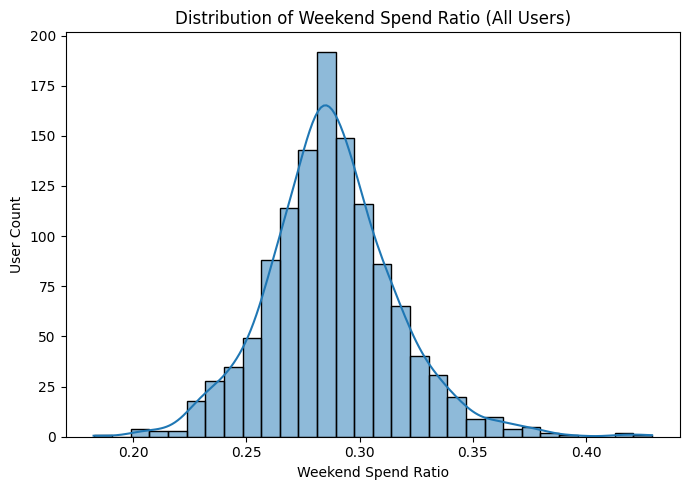

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(customer_agg['weekend_spend_ratio'], bins=30, kde=True, ax=ax)
ax.set_title('Distribution of Weekend Spend Ratio (All Users)')
ax.set_xlabel('Weekend Spend Ratio')
ax.set_ylabel('User Count')
plt.tight_layout()
plt.show()

## Risk of Default Score
We combine credit quality, leverage, and card utilization into a single indicator:
- **Credit score component (50%)** — lower FICO-like scores boost risk.
- **Debt-to-income component (30%)** — higher leverage pushes risk toward 1 after clipping at 1.5× income.
- **Spend-to-limit component (20%)** — sustained high utilization raises risk.

Scores are clipped to stay between 0 (least risky) and 1 (most risky).

In [30]:
risk_summary = customer_agg['risk_of_default_score'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).round(3)
display(risk_summary)

count    1219.000
mean        0.524
std         0.135
min         0.115
10%         0.325
25%         0.416
50%         0.554
75%         0.627
90%         0.677
max         0.828
Name: risk_of_default_score, dtype: float64

### Spend distribution and mix by risk tier
The next cells profile total spend and transaction composition for each risk tier (Low, Medium, High, Unscored). From the histograms, we can see that the categories are similar across risk tiers.

,user_count,total_spent,avg_spent
risk_level,,,
Low,134.0,6795994.77,50716.38
Medium,928.0,42988328.10,46323.63
High,157.0,7323010.78,46643.38
Unscored,NaN,NaN,NaN


/tmp/nix-shell.dcXrrX/ipykernel_129206/1882376688.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


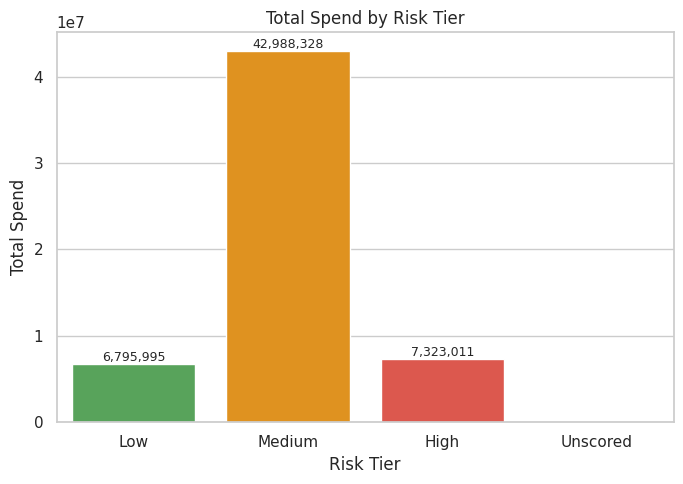

In [34]:
risk_level_order = ['Low', 'Medium', 'High', 'Unscored']
risk_spend_stats = (
    customer_agg.groupby('risk_level', observed=True)['total_spent']
    .agg(user_count='count', total_spent='sum', avg_spent='mean')
    .reindex(risk_level_order)
    .round({'total_spent': 2, 'avg_spent': 2})
)
display(risk_spend_stats)

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(
    x=risk_spend_stats.index,
    y=risk_spend_stats['total_spent'],
    palette=['#4caf50', '#ff9800', '#f44336', '#9e9e9e'],
    ax=ax
)
ax.set_title('Total Spend by Risk Tier')
ax.set_xlabel('Risk Tier')
ax.set_ylabel('Total Spend')
for p, value in zip(ax.patches, risk_spend_stats['total_spent']):
    ax.annotate(
        f"{value:,.0f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=9
    )
plt.tight_layout()
plt.show()

In [35]:
top_n = 5
risk_transactions = (
    df[['user_id', 'description', 'category', 'positive_amount']]
    .merge(customer_agg[['user_id', 'risk_level']], on='user_id', how='left')
)
risk_transactions = risk_transactions[
    risk_transactions['risk_level'].isin(risk_level_order)
].copy()
risk_transactions['risk_level'] = risk_transactions['risk_level'].astype('category').cat.reorder_categories(
    risk_level_order,
    ordered=True
)

def _top_k(df_group, column):
    aggregated = (
        df_group
        .dropna(subset=[column])
        .groupby(['risk_level', column], observed=True)['positive_amount']
        .sum()
        .reset_index()
    )
    aggregated['rank'] = aggregated.groupby('risk_level')['positive_amount'].rank(
        method='dense', ascending=False
    )
    top_k = aggregated[aggregated['rank'] <= top_n]
    return (
        top_k
        .sort_values(['risk_level', 'rank'])
        .rename(columns={'positive_amount': 'total_positive_amount'})
    )

top_descriptions = _top_k(risk_transactions, 'description')
top_categories = _top_k(risk_transactions, 'category')

print(f"Top {top_n} descriptions by spend within each risk tier:")
display(top_descriptions)

print(f"Top {top_n} categories by spend within each risk tier:")
display(top_categories)

Top 5 descriptions by spend within each risk tier:


/tmp/nix-shell.dcXrrX/ipykernel_129206/2870091605.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated['rank'] = aggregated.groupby('risk_level')['positive_amount'].rank(
/tmp/nix-shell.dcXrrX/ipykernel_129206/2870091605.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated['rank'] = aggregated.groupby('risk_level')['positive_amount'].rank(


,risk_level,description,total_positive_amount,rank
87,Low,Service Stations,561801.17,1.0
70,Low,Money Transfer,538697.81,2.0
45,Low,"Grocery Stores, Supermarkets",519081.05,3.0
106,Low,Wholesale Clubs,470052.41,4.0
33,Low,Drug Stores and Pharmacies,427087.34,5.0
178,Medium,Money Transfer,3869711.52,1.0
195,Medium,Service Stations,3835664.04,2.0
153,Medium,"Grocery Stores, Supermarkets",3092577.54,3.0
214,Medium,Wholesale Clubs,2890217.32,4.0
172,Medium,Miscellaneous Food Stores,2770687.61,5.0


Top 5 categories by spend within each risk tier:


,risk_level,category,total_positive_amount,rank
7,Low,Shopping & Retail,1733313.18,1.0
8,Low,Transportation & Travel,1641817.17,2.0
2,Low,Food & Dining,1506168.11,3.0
4,Low,Home & Utilities,782914.06,4.0
1,Low,Financial & Insurance,679544.65,5.0
16,Medium,Shopping & Retail,11145209.72,1.0
17,Medium,Transportation & Travel,10450614.78,2.0
11,Medium,Food & Dining,9861069.73,3.0
13,Medium,Home & Utilities,5376458.23,4.0
10,Medium,Financial & Insurance,4856926.53,5.0


### Top spend categories by risk tier
The summary below lists the five highest-spend `category` values for each risk tier, ordered by total positive spend.

In [ ]:
category_summary = []
for level in risk_level_order:
    level_slice = top_categories[top_categories['risk_level'] == level]
    if level_slice.empty:
        continue
    category_summary.append({
        'risk_level': level,
        'top_categories': ", ".join(
            level_slice['category'].astype(str)
        ),
        'spend_values': ", ".join(
            level_slice['total_positive_amount'].map(lambda v: f"${v:,.0f}")
        )
    })
category_summary_df = pd.DataFrame(category_summary)
display(category_summary_df)

## Trend alignment with monthly spending
We measure how each user's month-over-month spending changes track the portfolio-wide trend. The correlation threshold of $0.25$ distinguishes users who roughly follow the overall pattern from those who diverge materially.


In [23]:
monthly_total_spend = (
    df.set_index('date')['amount']
      .resample('MS')
      .sum()
      .rename('total_monthly_spend')
      .to_frame()
)

monthly_total_spend['monthly_diff'] = monthly_total_spend['total_monthly_spend'].diff().fillna(0)
overall_diff = monthly_total_spend['monthly_diff']
overall_months = monthly_total_spend.index

user_monthly_spend = (
    df.groupby(['user_id', pd.Grouper(key='date', freq='MS')])['amount']
      .sum()
      .reset_index()
      .rename(columns={'date': 'month', 'amount': 'user_monthly_spend'})
)

def _corr_with_overall(group):
    aligned = (
        group.set_index('month')
             .reindex(overall_months, fill_value=0)['user_monthly_spend']
    )
    user_diff = aligned.diff().fillna(0)
    if np.isclose(user_diff.var(), 0) or np.isclose(overall_diff.var(), 0):
        return 0.0
    return user_diff.corr(overall_diff)

monthly_correlations = (
    user_monthly_spend.groupby('user_id')
    .apply(_corr_with_overall)
    .rename('correlation_with_trend')
    .reset_index()
)

corr_threshold = 0.25
monthly_correlations['trend_category'] = np.where(
    monthly_correlations['correlation_with_trend'] >= corr_threshold,
    'Follows Trend',
    'Does Not Follow Trend'
)

trend_summary = (
    monthly_correlations.merge(
        customer_agg[['user_id', 'total_spent']],
        on='user_id',
        how='left'
)
    .groupby('trend_category')
    .agg(
        user_count=('user_id', 'nunique'),
        avg_total_spent=('total_spent', 'mean')
    )
    .round({'avg_total_spent': 2})
    .reindex(['Follows Trend', 'Does Not Follow Trend'])
)

display(monthly_total_spend.reset_index())
display(monthly_correlations.head())
display(trend_summary)

/tmp/nix-shell.dcXrrX/ipykernel_129206/1961933822.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_corr_with_overall)


,date,total_monthly_spend,monthly_diff
0,2010-01-01,433069.34,0.00
1,2010-02-01,419671.62,-13397.72
2,2010-03-01,449766.88,30095.26
3,2010-04-01,432030.36,-17736.52
4,2010-05-01,466837.08,34806.72
...,...,...,...
113,2019-06-01,476697.86,-32117.79
114,2019-07-01,505290.97,28593.11
115,2019-08-01,500952.31,-4338.66
116,2019-09-01,496500.64,-4451.67


,user_id,correlation_with_trend,trend_category
0,0,0.059359,Does Not Follow Trend
1,1,0.081096,Does Not Follow Trend
2,2,0.109820,Does Not Follow Trend
3,3,0.107009,Does Not Follow Trend
4,4,0.117612,Does Not Follow Trend


,user_count,avg_total_spent
trend_category,,
Follows Trend,46,56570.27
Does Not Follow Trend,1173,46466.41


### Monthly trend correlation distribution
The histogram below shows how users' month-over-month spending correlations stack up against the $0.25$ threshold, making it easy to spot segments that move with or against the portfolio trend.

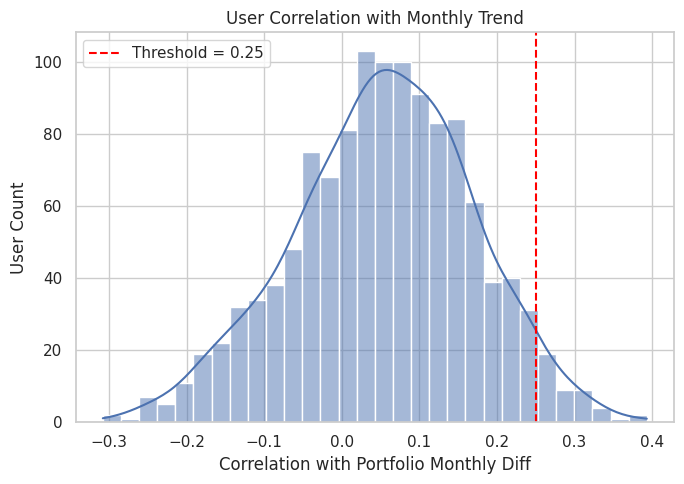

,user_count,avg_total_spent
trend_category,,
Follows Trend,46,56570.27
Does Not Follow Trend,1173,46466.41


In [25]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(
    monthly_correlations['correlation_with_trend'],
    bins=30,
    kde=True,
    ax=ax
)
ax.axvline(corr_threshold, color='red', linestyle='--', label=f'Threshold = {corr_threshold}')
ax.set_title('User Correlation with Monthly Trend')
ax.set_xlabel('Correlation with Portfolio Monthly Diff')
ax.set_ylabel('User Count')
ax.legend()
plt.tight_layout()
plt.show()

display(trend_summary)

In [ ]:
# PCA analysis on customer metrics
numeric_features = [
    'recency_days', 'tenure_days', 'txn_count', 'total_spent', 'avg_spent', 'max_spent',
    'txn_per_day', 'spend_per_txn','merchant_count', 'merchant_city_count',
    'merchant_state_count', 'merchant_zip_count', 'mcc_count', 'category_count', 'unique_cards',
    'merchant_count_per_month', 'user_current_age', 'user_retirement_age', 
   'user_gender_code', 'user_per_capita_income', 'user_yearly_income',
    'user_total_debt', 'debt_to_income_ratio', 'income_to_debt_ratio', 'user_credit_score',
    'user_num_credit_cards',
    'card_credit_limit', 'card_year_pin_last_changed', 'card_account_age_years',
    'card_time_to_expiry_years', 'spend_to_limit_ratio',
    'positive_spend', 'weekend_spend_ratio',
    'risk_of_default_score'
 ]

feature_matrix = customer_agg[numeric_features].copy()
feature_matrix = feature_matrix.fillna(feature_matrix.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_matrix)

pca = PCA()
principal_components = pca.fit_transform(X_scaled)

explained_variance = pd.DataFrame({
    'principal_component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'explained_variance_ratio': pca.explained_variance_ratio_,
    'cumulative_variance_ratio': np.cumsum(pca.explained_variance_ratio_)
})

pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=numeric_features
)

important_features = pca_loadings['PC1'].abs().sort_values(ascending=False).rename('abs_loading_PC1')

explained_variance.head(10), pca_loadings.head(10), important_features.head(15)

(  principal_component  explained_variance_ratio  cumulative_variance_ratio
 0                 PC1                  0.261529                   0.261529
 1                 PC2                  0.111639                   0.373168
 2                 PC3                  0.070062                   0.443230
 3                 PC4                  0.050730                   0.493960
 4                 PC5                  0.047566                   0.541526
 5                 PC6                  0.046613                   0.588139
 6                 PC7                  0.040837                   0.628975
 7                 PC8                  0.034149                   0.663124
 8                 PC9                  0.032574                   0.695699
 9                PC10                  0.031322                   0.727021,
                           PC1       PC2       PC3       PC4       PC5  \
 recency_days        -0.034739  0.123608  0.040538 -0.274013 -0.024545   
 tenure_days   

### Clustering workflow

In [13]:
max_features = 3
corr_threshold = 0.85

candidate_features = important_features.index.tolist()
top_features = []
for feature in candidate_features:
    if feature not in customer_agg.columns:
        continue
    is_correlated = any(
        abs(customer_agg[feature].corr(customer_agg[selected])) > corr_threshold
        for selected in top_features
    )
    if is_correlated:
        continue
    top_features.append(feature)
    if len(top_features) == max_features:
        break

if 'weekend_spend_ratio' in customer_agg.columns and 'weekend_spend_ratio' not in top_features:
    if len(top_features) < max_features:
        top_features.append('weekend_spend_ratio')
    else:
        replaced = top_features[-1]
        top_features[-1] = 'weekend_spend_ratio'
        print(f"Replaced {replaced} with weekend_spend_ratio to diversify features")

print(f"Top features selected for clustering: {top_features}")

X_features = customer_agg[top_features]
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X_features)

TARGET_K = 4  # Set to None to pick k via silhouette score
kmeans = KMeans(n_clusters=TARGET_K , random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_scaled)
customer_agg['Cluster'] = labels

Replaced mcc_count with weekend_spend_ratio to diversify features
Top features selected for clustering: ['merchant_city_count', 'total_spent', 'weekend_spend_ratio']


### Why k-means and how to explain the segments
1. **Transparent centroids:** k-means returns a centroid (mean feature vector) for each cluster. Comparing centroids shows which features drive each segment—for example, high `txn_count` plus low `recency_days` maps to “recent heavy spenders.”
2. **Feature importance cues:** The PCA loadings that selected `top_features` reveal which variables separate the data most. Combine them with centroid values to narrate segments.
3. **Per-cluster profiling:** Aggregating `customer_agg` by `Cluster` (means/medians, counts, proportions) builds human-readable personas. The `cluster_profile` table below already provides a starting point.
4. **Member-level explanations:** Distance to the assigned centroid clarifies how typical a user is. High distances flag edge cases worth reviewing individually.
5. **Visual storytelling:** Scatterplots or boxplots of the chosen features, colored by cluster labels, make differences intuitive for stakeholders.

### How the top features differentiate clusters
The next cells summarize and visualize how `merchant_count`, `merchant_city_count`, and `merchant_zip_count` shape each segment.

In [14]:
from IPython.display import display

top_feature_summary = (
    customer_agg.groupby('Cluster')[top_features]
    .agg(['mean', 'median', 'std'])
    .round(2)
)
display(top_feature_summary)
print("\nCorrelation matrix among selected features:")
display(customer_agg[top_features].corr().round(2))

merchant_city_count               total_spent                      \
                       mean median    std        mean    median       std   
Cluster                                                                     
0                     98.12   97.0  22.56    99735.61  94177.99  31868.15   
1                     39.95   40.5  12.70    27948.81  26375.24  11665.49   
2                     51.14   52.0  17.79    32949.89  32262.06  14283.27   
3                     71.81   70.0  14.71    51556.28  50318.11  15441.84   

        weekend_spend_ratio               
                       mean median   std  
Cluster                                   
0                      0.29   0.29  0.02  
1                      0.27   0.27  0.02  
2                      0.32   0.32  0.02  
3                      0.28   0.28  0.02


Correlation matrix among selected features:


,merchant_city_count,total_spent,weekend_spend_ratio
merchant_city_count,1.00,0.60,-0.04
total_spent,0.60,1.00,-0.06
weekend_spend_ratio,-0.04,-0.06,1.00


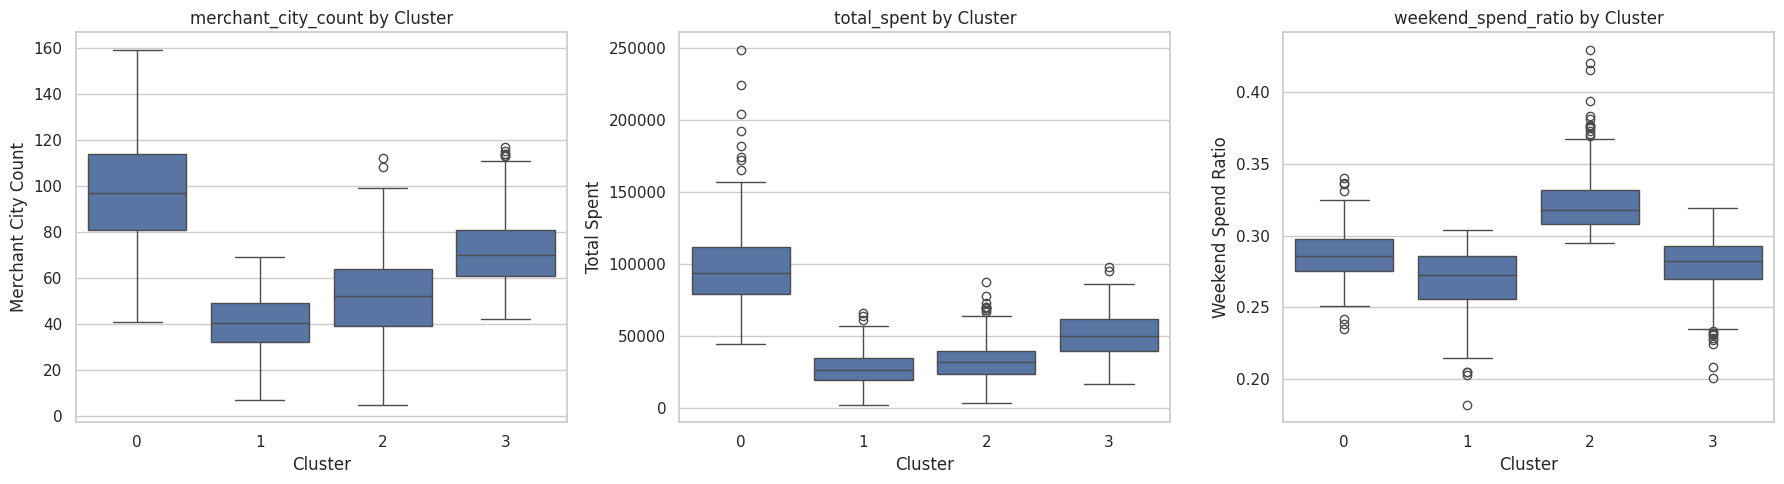

In [15]:


plot_df = customer_agg[['Cluster'] + top_features].copy()
plot_df['Cluster'] = plot_df['Cluster'].astype('category')

sns.set(style='whitegrid', context='notebook')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, feature in zip(axes, top_features):
    sns.boxplot(data=plot_df, x='Cluster', y=feature, ax=ax)
    ax.set_title(f'{feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature.replace('_', ' ').title())

plt.tight_layout()
plt.show()

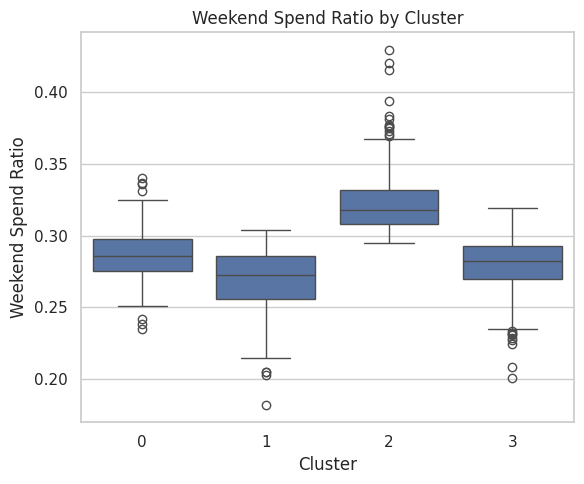

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
sns.boxplot(data=customer_agg, x='Cluster', y='weekend_spend_ratio', ax=ax)
ax.set_title('Weekend Spend Ratio by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Weekend Spend Ratio')
plt.tight_layout()
plt.show()

### Cluster printing and export 

In [17]:
cluster_profile = customer_agg.groupby('Cluster').agg(
    customer_count=('user_id', 'nunique'),
    recency_days_mean=('recency_days', 'mean'),
    tenure_days_mean=('tenure_days', 'mean'),
    txn_count_mean=('txn_count', 'mean'),
    total_spent_mean=('total_spent', 'mean'),
).round(2).sort_index()

clustering_df = customer_agg[['user_id', 'Cluster']]
clustering_df.to_csv('clustering_df_pca.csv', index=False)
print("Cluster assignments saved to clustering_df_pca.csv")

cluster_profile

Cluster assignments saved to clustering_df_pca.csv


,customer_count,recency_days_mean,tenure_days_mean,txn_count_mean,total_spent_mean
Cluster,,,,,
0,173,6.33,3561.08,1829.47,99735.61
1,370,35.38,3397.62,793.49,27948.81
2,287,24.65,3445.51,867.24,32949.89
3,389,4.02,3551.47,1212.34,51556.28
